In [1]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyro
from pyro.distributions import Normal, LogNormal, Uniform, Exponential
import torch
tt =  torch.tensor

from models import RegressionBase
from utils import sample_posterior, sample_prior, precis, WAIC, HPDI

In [2]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Sat Aug 03 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
matplotlib: 3.9.0
pyro      : 1.9.1
torch     : 2.3.0
numpy     : 1.26.4
pandas    : 2.2.2

Watermark: 2.4.3



### Code 8.1
Prepare the terrain ruggedness in Africa dataset

In [3]:
rugged_df = pd.read_csv("data/rugged.csv", sep=";")
rugged_df.sample(5)

,isocode,isonum,country,rugged,rugged_popw,rugged_slope,rugged_lsd,rugged_pc,land_area,lat,...,africa_region_w,africa_region_e,africa_region_c,slave_exports,dist_slavemkt_atlantic,dist_slavemkt_indian,dist_slavemkt_saharan,dist_slavemkt_redsea,pop_1400,european_descent
54,DJI,262,Djibouti,2.432,0.804,6.416,0.627,39.024,2318.0,11.735,...,0,1,0,4.176,14.408,2.682,2.351,0.064,34822.0,NaN
63,ESP,724,Spain,1.689,0.810,5.062,0.472,23.372,49900.0,40.231,...,0,0,0,0.000,NaN,NaN,NaN,NaN,5500000.0,99.24
166,PNG,598,Papua New Guinea,1.589,0.980,4.217,0.491,25.222,45286.0,-6.476,...,0,0,0,0.000,NaN,NaN,NaN,NaN,866855.0,0.00
100,ISL,352,Iceland,1.472,0.557,5.318,0.435,20.729,10025.0,64.990,...,0,0,0,0.000,NaN,NaN,NaN,NaN,60000.0,NaN
165,PLW,585,Palau,0.475,0.380,1.293,0.148,0.000,46.0,7.801,...,0,0,0,0.000,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
rugged_df[["cont_africa", "country", "rugged", "rgdppc_2000"]].sample(10)

,cont_africa,country,rugged,rgdppc_2000
2,1,Angola,0.858,1794.729
181,1,Sudan,0.442,1682.674
96,0,British Indian Ocean Territory,0.018,NaN
21,0,Bahrain,0.231,15928.090
41,1,Democratic Republic of the Congo,0.443,668.663
136,0,Myanmar,1.988,NaN
232,1,Zambia,0.533,774.010
81,1,Equatorial Guinea,0.559,15189.540
196,0,Sweden,0.715,25899.880
20,0,Bulgaria,1.479,5979.171


In [5]:
# make log version of outcome
rugged_df["log_gdp"] = np.log(rugged_df["rgdppc_2000"])
# extract countries with GDP data
dd = rugged_df[~rugged_df["rgdppc_2000"].isna()].copy()
# rescale variables
dd["log_gdp_std"] = dd["log_gdp"]/dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"]/dd["rugged"].max()
# split countries into africa and non-africa
dA1 = dd[dd["cont_africa"] == 1]
dA0 = dd[dd["cont_africa"] == 0]

In [6]:
dA0["log_gdp_std"].mean()

1.0489963244735097

### Code 8.2 - 8.6
Let's create two simple models that consider the African and non-African data separately.

In [7]:
class M8_1(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 1.))
        b = pyro.sample("b", Normal(0., 1.))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a + b*(self.rugged_std - 0.215)
            with pyro.plate("N"):
                pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            mu = a + b*(data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))

m8_1 = M8_1(dA1[["rugged_std", "log_gdp_std"]])

Let's take a look at what the prior thinks are good regression lines

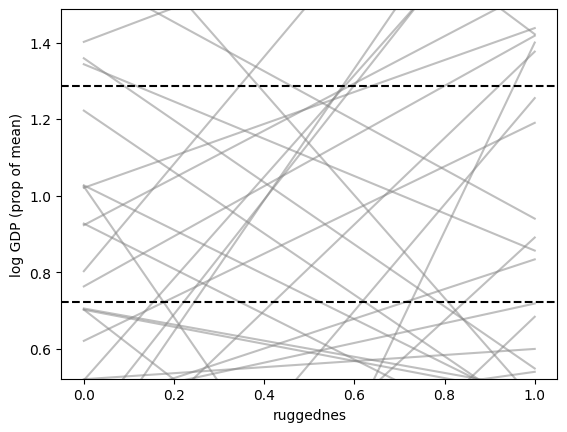

In [8]:
samples = sample_prior(m8_1, 50, ("a", "b"))
x = np.linspace(0, 1, 10)
for a, b in zip(*[samples[k] for k in ("a", "b")]):
    y = a + b*(x - 0.215)
    plt.plot(x, y, color="gray", alpha=0.5)
ymax = dd["log_gdp_std"].max()
ymin = dd["log_gdp_std"].min()
plt.axhline(ymax, color="black", linestyle="--")
plt.axhline(ymin, color="black", linestyle="--")
plt.ylim(top=ymax+0.2, bottom=ymin-0.2)
plt.xlabel("ruggednes")
plt.ylabel("log GDP (prop of mean)")
plt.show()

This looks like shit. Most of the lines predict GDP values outside the observed extemities (horizontal dashed lines). Let's tighten up the priors to make a more realistic prediction.

In [9]:
# A resonable extreme slope might be |b| ~ 0.6; what
# fraction of samples are more extreme than this?
sum(abs(samples["b"]) > 0.6) / len(samples["b"])

array([0.52])

In [10]:
class M8_1(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1))
        b = pyro.sample("b", Normal(0., 0.3))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a + b*(self.rugged_std - 0.215)
            with pyro.plate("N"):
                pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            mu = a + b*(data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))

m8_1 = M8_1(dA1[["rugged_std", "log_gdp_std"]])

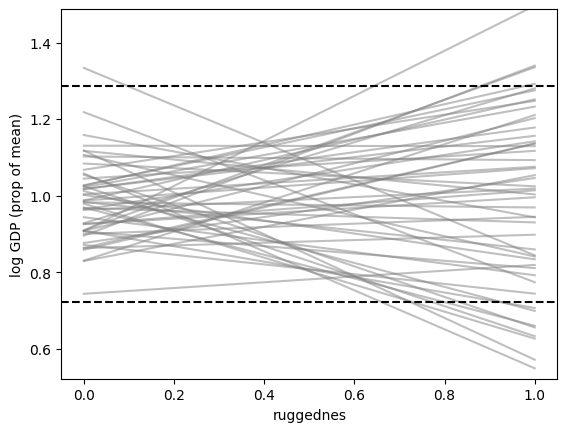

In [11]:
samples = sample_prior(m8_1, 50, ("a", "b"))
x = np.linspace(0, 1, 10)
for a, b in zip(*[samples[k] for k in ("a", "b")]):
    y = a + b*(x - 0.215)
    plt.plot(x, y, color="gray", alpha=0.5)
ymax = dd["log_gdp_std"].max()
ymin = dd["log_gdp_std"].min()
plt.axhline(ymax, color="black", linestyle="--")
plt.axhline(ymin, color="black", linestyle="--")
plt.ylim(top=ymax+0.2, bottom=ymin-0.2)
plt.xlabel("ruggednes")
plt.ylabel("log GDP (prop of mean)")
plt.show()

In [12]:
m8_1.train(3000)
samples = sample_posterior(m8_1, 10000, ("a", "b", "sigma"))
precis(samples, 0.89)

  0%|          | 0/3000 [00:00<?, ?it/s]

,mean,stddev,5.5%,94.5%
a,0.890971,0.015301,0.866283,0.915182
b,0.149818,0.068958,0.040441,0.260677
sigma,0.108395,0.010987,0.091621,0.126904


In [13]:
m8_2 = M8_1(dA0[["rugged_std", "log_gdp_std"]])
m8_2.train(3000)
samples = sample_posterior(m8_2, 10000, ("a", "b", "sigma"))
precis(samples, 0.89)

  0%|          | 0/3000 [00:00<?, ?it/s]

,mean,stddev,5.5%,94.5%
a,1.046794,0.010034,1.030617,1.062796
b,-0.134443,0.063728,-0.235874,-0.031321
sigma,0.11241,0.007331,0.101155,0.124425


### Code 8.7 - 8.12
Now let's try and figure out a way to include all the data in the same model rather than breaking it up into different datasets. First we will try making the intercept depend on the Africa 0/1 indicator. Specifically, we want to create two different intercepts like 

$\mu_i = \alpha[A_i] + \beta (r_i - \bar{r})$, instead of the typical $\mu_i = \alpha + \beta (r_i - \bar{r}) + \gamma A_i$, which will naturally lead to higher uncertainty for African nations since $\mu_i$ depends on 3 random variables rather than 2 for that subset of data.

  0%|          | 0/1000 [00:00<?, ?it/s]

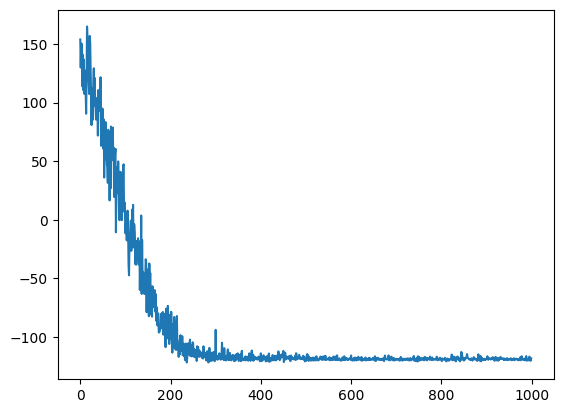

In [14]:
class M8_4(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(1))
        b = pyro.sample("b", Normal(0., 0.3))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a[self.cont_africa] + b * (self.rugged_std - 0.215)
            with pyro.plate("N"):
                pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            mu = a[data["cont_africa"]] + b * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_4 = M8_4(dd[["log_gdp_std", "rugged_std", "cont_africa"]], categoricals=("cont_africa",))
loss = m8_4.train(1000)
plt.plot(loss); plt.show()

Let's extract some samples and WAIC so that we can compare with other models.

In [15]:
samples = {"m8.4": sample_posterior(m8_4, 1000, ("a", "b", "sigma"))}
x = {k: getattr(m8_4, k) for k in ("log_gdp_std", "cont_africa", "rugged_std")}
waic = {"m8.4": WAIC(m8_4, x, x["log_gdp_std"], "log_gdp_std", 1000)}

Now to compare with the original linear model (without the Africa indicator), but trained on all the data

  0%|          | 0/1000 [00:00<?, ?it/s]

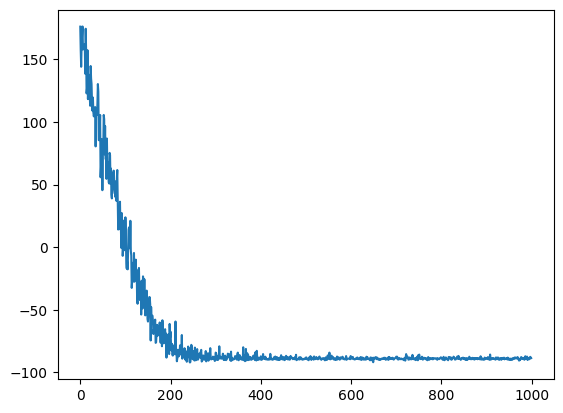

In [16]:
m8_3 = M8_1(dd[["log_gdp_std", "rugged_std"]])
loss = m8_3.train(1000)
plt.plot(loss); plt.show()

In [17]:
samples["m8.3"] = sample_posterior(m8_3, 1000, ("a", "b", "sigma"))
x = {k: getattr(m8_3, k) for k in ("log_gdp_std", "rugged_std")}
waic["m8.3"] = WAIC(m8_3, x, x["log_gdp_std"], "log_gdp_std", 1000)

In [18]:
waic_df = pd.DataFrame([
    {
        "WAIC": v.sum().item(),
        "SE": torch.sqrt(len(v)*v.var()).item(),
    } for k, v in waic.items()
], index=waic.keys())
m = waic_df.index[waic_df["WAIC"].argmin()]
for nm in waic_df.index:
    waic_df.loc[nm, "dWAIC"] = waic_df.loc[nm, "WAIC"] - waic_df.loc[m, "WAIC"]
    waic_df.loc[nm, "dSE"] = torch.sqrt(len(dd)*(waic[nm] - waic[m]).var()).item()
waic_df.sort_values("WAIC")

,WAIC,SE,dWAIC,dSE
m8.4,-251.579208,15.037771,0.000000,0.000000
m8.3,-188.558380,12.948850,63.020828,15.779226


In [19]:
s = samples["m8.4"].copy()
print(s["a"].shape)
for i in range(2):
    s[f"a[{i}]"] = s["a"].squeeze()[:,i]
del s["a"]
precis(s, 0.89)

(1000, 1, 2)


,mean,stddev,5.5%,94.5%
b,-0.011041,0.045721,-0.081904,0.060619
sigma,0.115555,0.006699,0.104988,0.126287
a[0],1.051296,0.010851,1.033859,1.068726
a[1],0.871407,0.015111,0.846673,0.895128


In [20]:
precis(samples["m8.3"], 0.89)

,mean,stddev,5.5%,94.5%
a,1.006142,0.010872,0.988244,1.023807
b,-0.005346,0.050795,-0.084503,0.074103
sigma,0.138918,0.00731,0.127551,0.150829


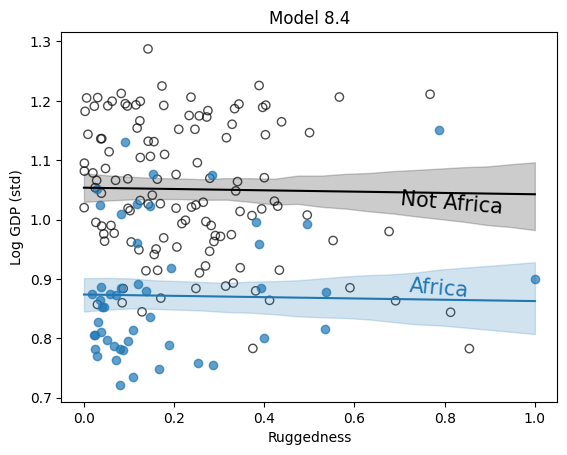

In [21]:
x = np.linspace(0, 1, 20)
s = samples["m8.4"]
for A, c in zip((0, 1), ("black", "C0")):
    # Sample mu
    mu = s["a"].squeeze()[:,A][:,None] + s["b"].squeeze()[:,None] * (x[None,:] - 0.215)
    # Calculate mean/HPDI
    mean = mu.mean(axis=0)
    hpdi = np.stack([HPDI(_s, 0.89) for _s in mu.T]).T
    # Plot regression lines
    plt.plot(x, mean, color=c)
    plt.fill_between(x, *hpdi, alpha=0.2, color=c)
    # Plot data
    _d = dd[dd["cont_africa"]==A]
    fc = "C0" if A else "none"
    plt.scatter(_d["rugged_std"], _d["log_gdp_std"], edgecolor=c, facecolor=fc, alpha=0.7)
plt.xlabel("Ruggedness")
plt.ylabel("Log GDP (std)")
plt.text(0.7, 1.01, "Not Africa", rotation=-4.9, fontsize=15)
plt.text(0.72, 0.87, "Africa", rotation=-4.9, fontsize=15, color="C0")
plt.title("Model 8.4")
plt.show()

### Code 8.13 - 8.18
Now we want to introduce an "interaction effect". The above plot shows that model 8.4 does capture the different means of African and non-African nations, but it cannot capture the difference in slope. To do that, we'll have to generalize our model so that the $\beta$ parameter depends on $A_i$:
$$\mu_i = \alpha[A_i] + \beta[A_i] (r_i - \bar{r})$$

  0%|          | 0/1000 [00:00<?, ?it/s]

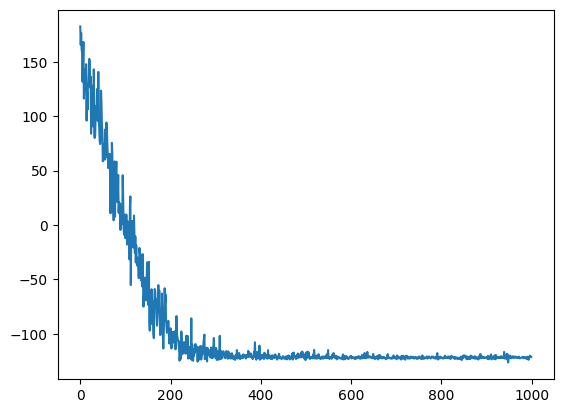

In [22]:
class M8_5(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(1., 0.1).expand([2]).to_event(1))
        b = pyro.sample("b", Normal(0., 0.3).expand([2]).to_event(1))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            A = self.cont_africa
            mu = a[A] + b[A] * (self.rugged_std - 0.215)
            with pyro.plate("N"):
                pyro.sample("log_gdp_std", Normal(mu, sigma), obs=self.log_gdp_std)
        else:
            A = data["cont_africa"]
            mu = a[A] + b[A] * (data["rugged_std"] - 0.215)
            return pyro.sample("log_gdp_std", Normal(mu, sigma))
            
m8_5 = M8_5(dd[["log_gdp_std", "rugged_std", "cont_africa"]], categoricals=("cont_africa",))
loss = m8_5.train(1000)
plt.plot(loss); plt.show()

In [23]:
samples["m8.5"] = sample_posterior(m8_5, 1000, ("a", "b", "sigma"))
x = {k: getattr(m8_5, k) for k in ("log_gdp_std", "rugged_std", "cont_africa")}
waic["m8.5"] = WAIC(m8_5, x, x["log_gdp_std"], "log_gdp_std", 1000)

In [24]:
s = samples["m8.5"].copy()
for i in (1, 2):
    s[f"a[{i}]"] = s["a"].squeeze()[:,i-1]
    s[f"b[{i}]"] = s["b"].squeeze()[:,i-1]
del s["a"], s["b"]
precis(s, 0.89)

,mean,stddev,5.5%,94.5%
sigma,0.113152,0.007021,0.102569,0.124747
a[1],1.053047,0.009299,1.037976,1.06757
b[1],-0.134335,0.052309,-0.220656,-0.053894
a[2],0.892754,0.014908,0.868743,0.916066
b[2],0.128151,0.072808,0.013343,0.246583


In [25]:
waic_df = pd.DataFrame([
    {
        "WAIC": v.sum().item(),
        "SE": torch.sqrt(len(v)*v.var()).item(),
    } for k, v in waic.items()
], index=waic.keys())
m = waic_df.index[waic_df["WAIC"].argmin()]
for nm in waic_df.index:
    waic_df.loc[nm, "dWAIC"] = waic_df.loc[nm, "WAIC"] - waic_df.loc[m, "WAIC"]
    waic_df.loc[nm, "dSE"] = torch.sqrt(len(dd)*(waic[nm] - waic[m]).var()).item()
waic_df.sort_values("WAIC")

,WAIC,SE,dWAIC,dSE
m8.5,-259.882629,13.870544,0.000000,0.000000
m8.4,-251.579208,15.037771,8.303421,6.994580
m8.3,-188.558380,12.948850,71.324249,14.426122


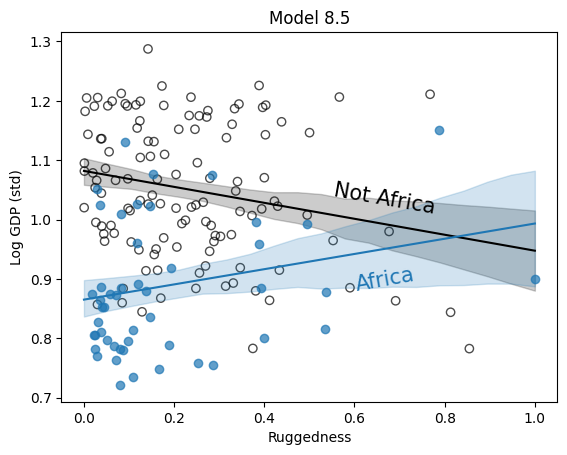

In [26]:
x = np.linspace(0, 1, 20)
s = samples["m8.5"]
for A, c in zip((0, 1), ("black", "C0")):
    # Sample mu
    mu = s["a"].squeeze()[:,A][:,None] + s["b"].squeeze()[:,A][:,None] * (x[None,:] - 0.215)
    # Calculate mean/HPDI
    mean = mu.mean(axis=0)
    hpdi = np.stack([HPDI(_s, 0.89) for _s in mu.T]).T
    # Plot regression lines
    plt.plot(x, mean, color=c)
    plt.fill_between(x, *hpdi, alpha=0.2, color=c)
    # Plot data
    _d = dd[dd["cont_africa"]==A]
    fc = "C0" if A else "none"
    plt.scatter(_d["rugged_std"], _d["log_gdp_std"], edgecolor=c, facecolor=fc, alpha=0.7)
plt.xlabel("Ruggedness")
plt.ylabel("Log GDP (std)")
plt.text(0.55, 1.01, "Not Africa", rotation=-10, fontsize=15)
plt.text(0.6, 0.88, "Africa", rotation=10, fontsize=15, color="C0")
plt.title("Model 8.5")
plt.show()

The typical interpretation is to say that the effect of ruggedness on log GDP depends on whether a country is in Africa or not. However, it is equally correct to say that the effect of being in Africa on log GDP depends on ruggedness. To visualize this, let's create a counter-factual plot showing the difference between two countries in or not in Africa, with the same ruggedness.

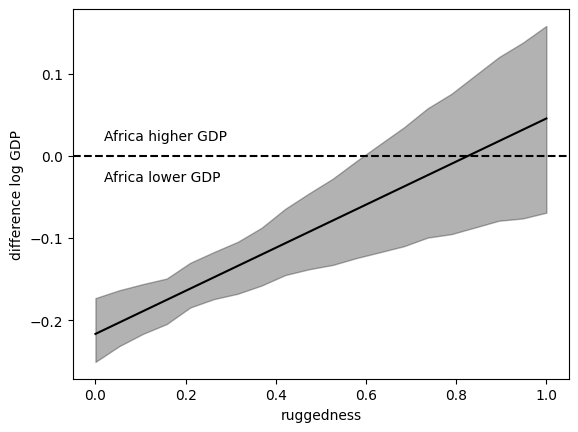

In [27]:
x = np.linspace(0, 1, 20)
s = samples["m8.5"]
mu = s["a"].squeeze()[:,:,None] + s["b"].squeeze()[:,:,None] * (x[None,None,:] - 0.215)
mu = (mu[:,1,:] - mu[:,0,:]).squeeze()
mean = mu.mean(axis=0)
hpdi = np.stack([HPDI(_s, 0.89) for _s in mu.T]).T
plt.plot(x, mean, color="black")
plt.fill_between(x, *hpdi, color="black", alpha=0.3)
plt.axhline(0, color="black", linestyle="--")
plt.text(0.02, 0.02, "Africa higher GDP")
plt.text(0.02, -0.03, "Africa lower GDP")
plt.xlabel("ruggedness")
plt.ylabel("difference log GDP")
plt.show()

### Code 8.19 - 8.24
Now that we have looked at interactions between a categorical and continuous variable (which amounts to having a different continuous variable for each category), what about the interaction between multiple continuous variables?

In [28]:
tulips_df = pd.read_csv("data/tulips.csv", sep=";")
tulips_df.sample(5)

,bed,water,shade,blooms
13,b,2,2,124.99
17,b,3,3,134.93
12,b,2,1,213.13
7,a,3,2,83.77
3,a,2,1,183.47


In [29]:
d = tulips_df.copy()
d["blooms_std"] = d["blooms"]/d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

#### $\alpha$ prior analysis

In [30]:
numsamples = 1000
a = Normal(0.5, 1).sample([numsamples])
((a<0) | (a>1)).sum()/numsamples

tensor(0.6100)

If it’s 0.5 units from the mean to zero, then a standard deviation of 0.25 should put only 5%
of the mass outside the valid interval.

In [31]:
numsamples = 1000
a = Normal(0.5, 0.25).sample([numsamples])
((a<0) | (a>1)).sum()/numsamples

tensor(0.0330)

First, let's just do a simple non-interacting linear regression for comparison later

  0%|          | 0/1000 [00:00<?, ?it/s]

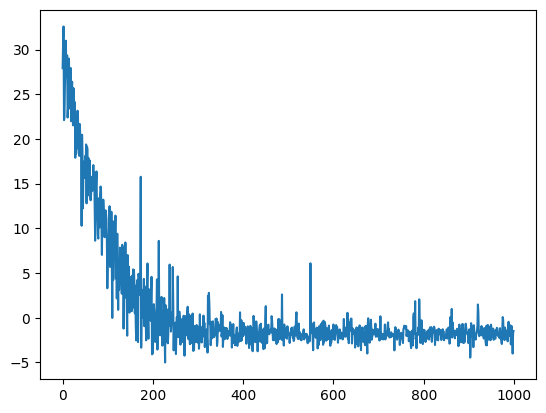

In [32]:
class M8_6(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(0.5, 0.25))
        bw = pyro.sample("bw", Normal(0., 0.25))
        bs = pyro.sample("bs", Normal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            mu = a + bw*self.water_cent + bs*self.shade_cent
            with pyro.plate("N"):
                pyro.sample("blooms_std", Normal(mu, sigma), obs=self.blooms_std)
        else:
            mu = a + bw*data["water_cent"] + bs*data["shade_cent"]
            return pyro.sample("blooms_std", Normal(mu, sigma))
        
m8_6 = M8_6(d[["blooms_std","water_cent","shade_cent"]])
loss = m8_6.train(1000)
plt.plot(loss); plt.show()

In [33]:
prior = {"m8.6": sample_prior(m8_6, 1000, ("a", "bw", "bs"))}
posterior = {"m8.6": sample_posterior(m8_6, 1000, ("a", "bw", "bs"))}

Now we want to build our interacting model. The slope of the centered water levels $W_i$, should depend on the centered shade levels $S_i$. If we pretend to do a linear regression of the slope of water $\gamma_{w,i}$ on shade, that gives us
$$
\mu_i = \alpha + \gamma_{w,i} W_i + \beta_s S_i \\
\gamma_{w,i} = \beta_w + \beta_{ws} S_i
$$

If we plug the second equation into the first, we arrive at the relation
$$
\mu_i = \alpha + \beta_w W_i + \beta_s S_i + \beta_{ws} S_i W_i
$$
which is the same as our previous linear model but with an additional multiplicative term between $W$ and $S$!

  0%|          | 0/2000 [00:00<?, ?it/s]

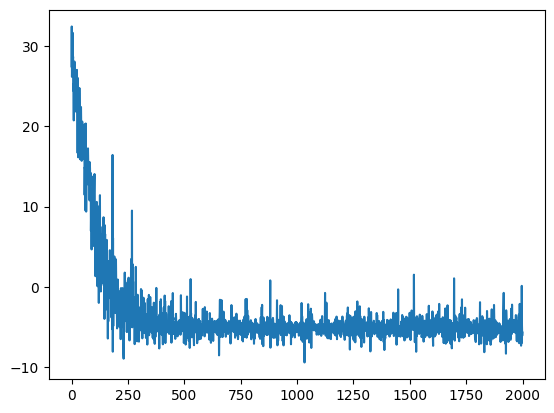

In [34]:
class M8_7(RegressionBase):
    def __call__(self, data=None):
        a = pyro.sample("a", Normal(0.5, 0.25))
        bw = pyro.sample("bw", Normal(0., 0.25))
        bs = pyro.sample("bs", Normal(0., 0.25))
        bws = pyro.sample("bws", Normal(0., 0.25))
        sigma = pyro.sample("sigma", Exponential(1.))
        if data is None:
            W, S = self.water_cent, self.shade_cent
            mu = a + bw*W + bs*S + bws*W*S
            with pyro.plate("N"):
                pyro.sample("blooms_std", Normal(mu, sigma), obs=self.blooms_std)
        else:
            W, S = data["water_cent"], data["shade_cent"]
            mu = a + bw*W + bs*S + bws*W*S
            return pyro.sample("blooms_std", Normal(mu, sigma))
        
m8_7 = M8_7(d[["blooms_std","water_cent","shade_cent"]])
loss = m8_7.train(2000)
plt.plot(loss); plt.show()

In [35]:
prior["m8.7"] = sample_prior(m8_7, 1000, ("a", "bw", "bs", "bws"))
posterior["m8.7"] = sample_posterior(m8_7, 1000, ("a", "bw", "bs", "bws"))

## Code 8.25 - 8.??
Make a "triptych" plot of two variables vs each other with the third held constant for both the non-interacting and interacting models

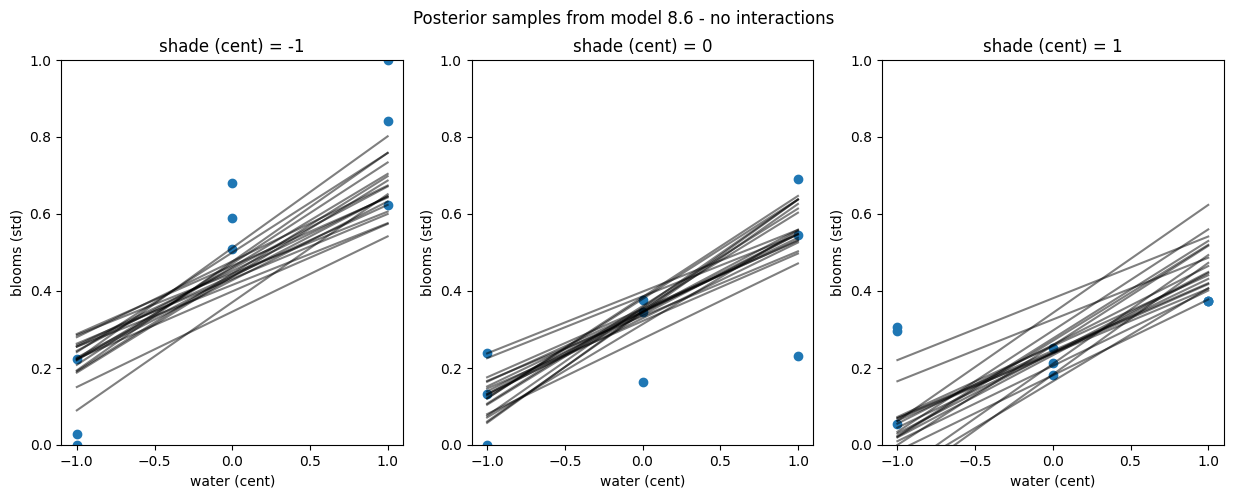

In [36]:
def triptych(samples, model_nm):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
    N = 20
    W = np.linspace(-1, 1)
    a = samples["a"][:N]
    bw = samples["bw"][:N]
    bs = samples["bs"][:N]
    bws = samples.get("bws", np.zeros(N))
    for S, ax in zip((-1, 0, 1), axes):
        plt.sca(ax)
        for i in range(20):
            mu = a[i] + bw[i]*W + bs[i]*S + bws[i]*W*S
            plt.plot(W, mu, color="black", alpha=0.5)
        _d = d[d["shade_cent"]==S]
        plt.scatter(_d["water_cent"], _d["blooms_std"], color="C0")
        plt.title(f"shade (cent) = {int(S)}")
        plt.xlabel("water (cent)")
        plt.ylabel("blooms (std)")
        plt.ylim(bottom=0, top=1)
    fig.suptitle(f"Posterior samples from model {model_nm}")
        
triptych(posterior["m8.6"], "8.6 - no interactions")

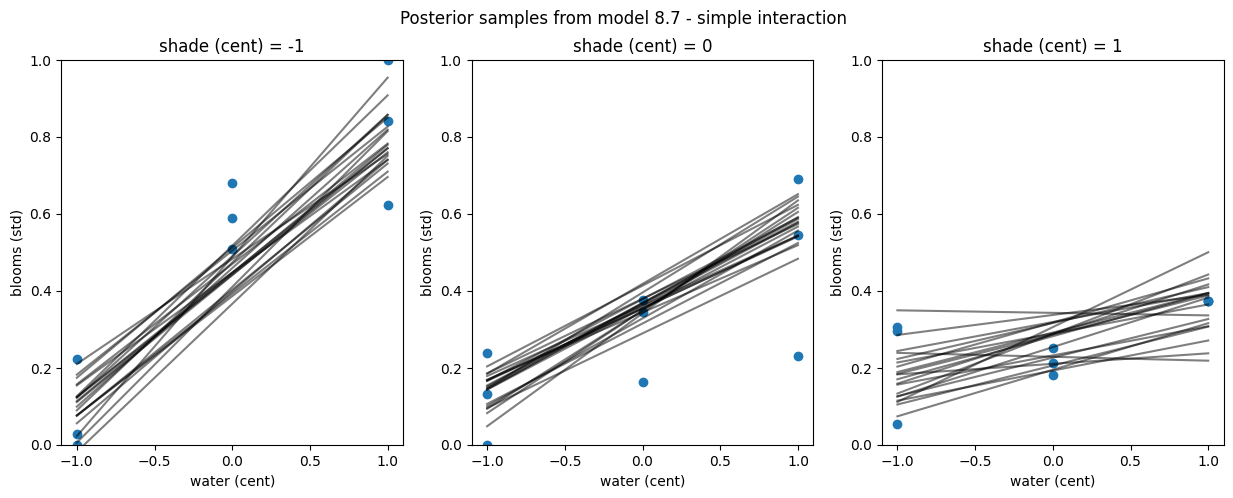

In [37]:
triptych(posterior["m8.7"], "8.7 - simple interaction")

We can see that in the non-interacting model (top), the slope of the water vs blooms regression is the same for all levels of shade. However in the interacting model (bottom), increasing the level of shade decreases the slope.

### Code 8.26
Now let's plot the priors that we set before, see if they're any good.

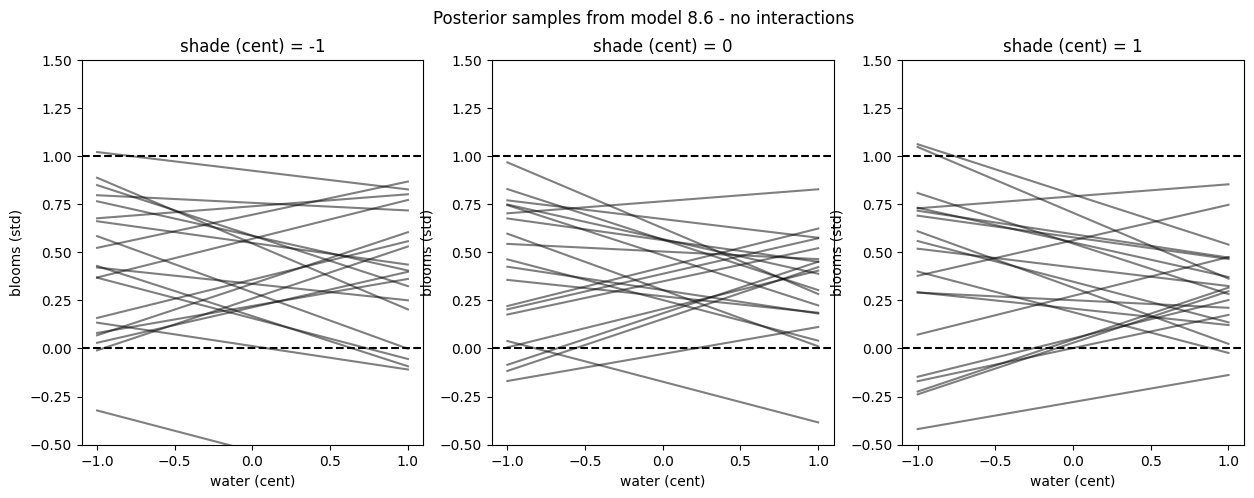

In [38]:
def triptych(samples, model_nm):
    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
    N = 20
    W = np.linspace(-1, 1)
    a = samples["a"][:N]
    bw = samples["bw"][:N]
    bs = samples["bs"][:N]
    bws = samples.get("bws", np.zeros(N))
    for S, ax in zip((-1, 0, 1), axes):
        plt.sca(ax)
        for i in range(20):
            mu = a[i] + bw[i]*W + bs[i]*S + bws[i]*W*S
            plt.plot(W, mu, color="black", alpha=0.5)
        plt.axhline(0, color="black", linestyle="--")
        plt.axhline(1, color="black", linestyle="--")
        plt.title(f"shade (cent) = {int(S)}")
        plt.xlabel("water (cent)")
        plt.ylabel("blooms (std)")
        plt.ylim(bottom=-0.5, top=1.5)
    fig.suptitle(f"Posterior samples from model {model_nm}")
        
triptych(prior["m8.6"], "8.6 - no interactions")

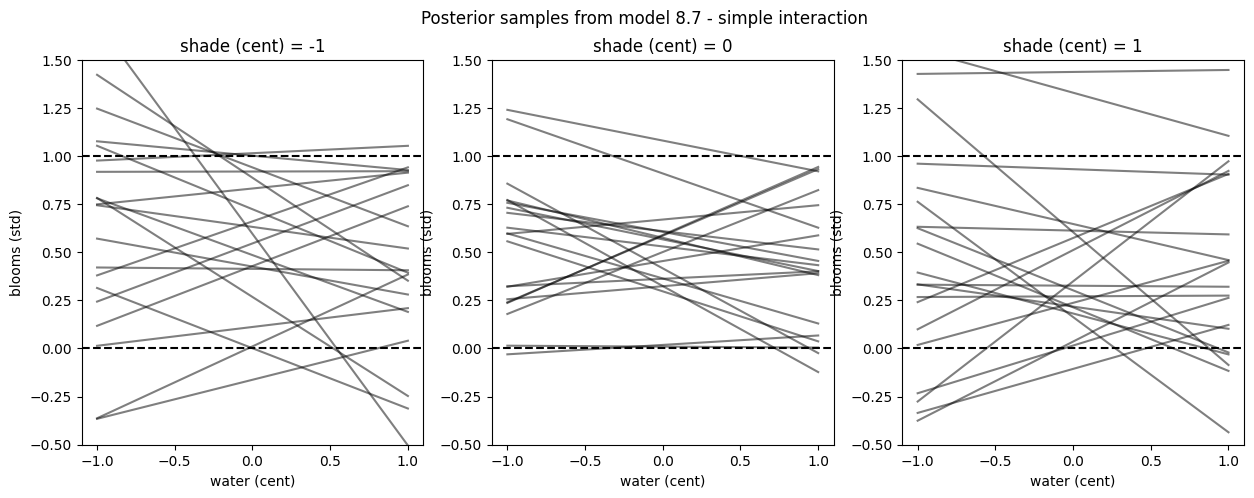

In [39]:
triptych(prior["m8.7"], "8.7 - simple interaction")